### Generate sample output plots
Use this notebook to create sample output plots from a Temoa database that contains results. Modify the path to the database and scenario name in the cell below and run all cells to use the notebook. For cells with widgets, select some combination of sector, regions, periods and demand categories to view the output plots.

In [1]:
db_path = '../data_aggregation/US_BASE_solved.sqlite'
scenario = 'test_run'

In [2]:
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from ipywidgets import HBox, VBox, Layout

import ipywidgets as widgets
from ipywidgets import HBox, VBox, Layout

from IPython.display import HTML,Markdown



def controls_rows(w):
    controls = HBox(w.children[:-1], layout = Layout(flex_flow='row wrap', width='max-content'))
    output = w.children[-1]
    display(VBox([controls, output],  layout = Layout(flex_flow='columns wrap', width='max-content', size=10)))
    
import plotly.graph_objects as go
import plotly.express as pex
#import plotly.io as pio

con = sqlite3.connect(db_path)#change path to database
sb.set(style='darkgrid', font_scale=1.2)

#return sankey diagram dataframe for a sector
def sankey_df(con, scenario, sector, region, t_periods):
    if sector =='commercial':
        fuels_list = ['C_DISTOIL','C_LPG','C_NGA','C_RFO','ELC','SNG_100','H2_100', 'ELCDIST_R']
    elif sector=='residential':
        fuels_list = ['R_DISTOIL','R_LPG','R_NGA','R_KER','RWHSOL', 'R_BIO','ELC','SNG_100','H2_100', 'ELCDIST_R']
    elif sector == 'transport':
        fuels_list = ['MGO','DSL','GAS','CNG','ETHANOL', 'JTF', 'RFO', 'T_LPG','MEOH', 'T_Liquids', 'ELC', 'BIODSL', 'BIO_JTF', 'ELCDIST_R']
    elif sector == 'industrial':
        fuels_list = ['I_COAL', 'I_DFO', 'I_GSL',  'I_NGA', 'I_REN', 'I_RFO', 'I_LPG', 'I_OTH_EA', 'SNG_100', 'MEOH', 'H2_100', 'ELC', 'ELCDIST_R']
    else:
        print('Sector input is either residential, commercial, industrial, or transport')
    
    if region=='All':
        query = "SELECT input_comm, output_comm, SUM(vflow_in) AS vflow_in FROM Output_VFlow_In \
    WHERE scenario='" + scenario + "' AND sector='" + sector + "' AND t_periods="+ str(t_periods) + \
    " GROUP BY sector, input_comm, output_comm ORDER BY input_comm, output_comm"
    else:
        query = "SELECT input_comm, output_comm, SUM(vflow_in) AS vflow_in FROM Output_VFlow_In \
    WHERE scenario='" + scenario + "' AND sector='" + sector + "' AND t_periods="+ str(t_periods) + " AND regions='"+ str(region) +\
    "' GROUP BY sector, input_comm, output_comm ORDER BY input_comm, output_comm"

    df_sector = pd.read_sql_query(query, con)
    df_sector = df_sector[df_sector['input_comm'].isin(fuels_list)]
    df_demands = pd.read_sql_query("SELECT comm_name FROM commodities WHERE flag='d'", con)
    mask = df_sector['output_comm'].isin(list(df_demands['comm_name'].values))
    iterval = 1
    while len(df_sector[mask]) < len(df_sector):
        df_sector_remains = df_sector[mask]
        df_sector = df_sector[~mask]
        if region=='All':
            query = "SELECT input_comm, output_comm, SUM(vflow_in) AS split FROM Output_VFlow_In \
            WHERE input_comm IN ('" + "','".join(df_sector['output_comm'].unique()) + "') AND \
            scenario='" + scenario + "' AND sector='" + sector + "' AND t_periods="+ str(t_periods) +\
            " GROUP BY sector, input_comm, output_comm"
        else:
            query = "SELECT input_comm, output_comm, SUM(vflow_in) AS split FROM Output_VFlow_In \
            WHERE input_comm IN ('" + "','".join(df_sector['output_comm'].unique()) + "') AND \
            scenario='" + scenario + "' AND sector='" + sector + "' AND t_periods="+ str(t_periods) + " AND regions='"+ str(region) +\
            "' GROUP BY sector, input_comm, output_comm"

        df_eff = pd.read_sql_query(query, con)
        df_eff.drop_duplicates(inplace=True)
        df_eff = df_eff.merge(df_eff.groupby(by='input_comm').sum().reset_index(),on='input_comm' )
        df_eff['split'] = df_eff['split_x']/df_eff['split_y']

        df_sector = df_sector.merge(df_eff, left_on = 'output_comm', right_on='input_comm', how='left')
        df_sector['vflow_in'] = df_sector['vflow_in']*df_sector['split']
        df_sector = df_sector[['input_comm_x', 'output_comm_y','vflow_in']]
        df_sector.rename(columns={'input_comm_x':'input_comm', 'output_comm_y':'output_comm'}, inplace=True)
        df_sector = pd.concat([df_sector, df_sector_remains])
        mask = df_sector['output_comm'].isin(list(df_demands['comm_name'].values))

        iterval+=1
        if iterval>10:
            break
    df_sector.rename(columns={'input_comm':'Source', 'output_comm':'Destination', 'vflow_in':'Flow'}, inplace=True)
    return df_sector

def sankey_df_demand(con, scenario, sector, t_periods, region, demand):
    if sector =='commercial':
        fuels_list = ['C_DISTOIL','C_LPG','C_NGA','C_RFO','ELC','SNG_100','H2_100', 'ELCDIST_R']
    elif sector=='residential':
        fuels_list = ['R_DISTOIL','R_LPG','R_NGA','R_KER','RWHSOL', 'R_BIO','ELC','SNG_100','H2_100', 'ELCDIST_R']
    elif sector == 'transport':
        fuels_list = ['MGO','DSL','GAS','CNG','ETHANOL', 'JTF', 'RFO', 'T_LPG','MEOH', 'T_Liquids', 'ELC', 'BIODSL', 'BIO_JTF', 'ELCDIST_R']
    elif sector == 'industrial':
        fuels_list = ['I_COAL', 'I_DFO', 'I_GSL',  'I_NGA', 'I_REN', 'I_RFO', 'I_LPG', 'I_OTH_EA', 'SNG_100', 'MEOH', 'H2_100', 'ELC', 'ELCDIST_R']
    else:
        print('Sector input is either residential, commercial, industrial, or transport')
    
    if region=='All':
        query = "SELECT input_comm, output_comm, SUM(vflow_in) AS vflow_in FROM Output_VFlow_In \
    WHERE scenario='" + scenario + "' AND sector='" + sector + "' AND t_periods="+ str(t_periods) + \
    " GROUP BY sector, input_comm, output_comm ORDER BY input_comm, output_comm"
    else:
        query = "SELECT input_comm, output_comm, SUM(vflow_in) AS vflow_in FROM Output_VFlow_In \
    WHERE scenario='" + scenario + "' AND sector='" + sector + "' AND t_periods="+ str(t_periods) + " AND regions='"+ str(region) +\
    "' GROUP BY sector, input_comm, output_comm ORDER BY input_comm, output_comm"

    df_sector = pd.read_sql_query(query, con)
    df_sector = df_sector[df_sector['input_comm'].isin(fuels_list)]
    df_demands = pd.read_sql_query("SELECT comm_name FROM commodities WHERE flag='d'", con)
    mask = df_sector['output_comm'].isin(list(df_demands['comm_name'].values))
    iterval = 1
    while len(df_sector[mask]) < len(df_sector):
        df_sector_remains = df_sector[mask]
        df_sector = df_sector[~mask]
        if region=='All':
            query = "SELECT input_comm, output_comm, SUM(vflow_in) AS split FROM Output_VFlow_In \
            WHERE input_comm IN ('" + "','".join(df_sector['output_comm'].unique()) + "') AND \
            scenario='" + scenario + "' AND sector='" + sector + "' AND t_periods="+ str(t_periods) +\
            " GROUP BY sector, input_comm, output_comm"
        else:
            query = "SELECT input_comm, output_comm, SUM(vflow_in) AS split FROM Output_VFlow_In \
            WHERE input_comm IN ('" + "','".join(df_sector['output_comm'].unique()) + "') AND \
            scenario='" + scenario + "' AND sector='" + sector + "' AND t_periods="+ str(t_periods) + " AND regions='"+ str(region) +\
            "' GROUP BY sector, input_comm, output_comm"

        df_eff = pd.read_sql_query(query, con)
        df_eff.drop_duplicates(inplace=True)
        df_eff = df_eff.merge(df_eff.groupby(by='input_comm').sum().reset_index(),on='input_comm' )
        df_eff['split'] = df_eff['split_x']/df_eff['split_y']

        df_sector = df_sector.merge(df_eff, left_on = 'output_comm', right_on='input_comm', how='left')
        df_sector['vflow_in'] = df_sector['vflow_in']*df_sector['split']
        df_sector = df_sector[['input_comm_x', 'input_comm_y', 'output_comm_y','vflow_in']]
        df_sector.rename(columns={'input_comm_x':'input_comm', 'input_comm_y':'input_comm_int', 'output_comm_y':'output_comm'}, inplace=True)
        df_sector = pd.concat([df_sector, df_sector_remains])
        mask = df_sector['output_comm'].isin(list(df_demands['comm_name'].values))

        iterval+=1
        if iterval>10:
            break
    df_sector = df_sector[df_sector['output_comm']==demand]
    df_sector['input_comm_int'].fillna(df_sector['output_comm'], inplace=True)
    df_sector.rename(columns={'input_comm':'Source', 'input_comm_int':'Destination', 'vflow_in':'Flow'}, inplace=True)
    return df_sector

### Sankey diagram representing energy for end-use demands

In [3]:
def show_sankey_sector(con, scenario):
    
    sector = ['residential', 'commercial','transport','industrial']

    regions = pd.read_sql("SELECT regions FROM regions", con)
    regions = ['All'] + list(regions['regions'].values)

    period = pd.read_sql("SELECT t_periods FROM time_periods WHERE flag='f'", con)
    period = period['t_periods'].values
    period = period[:-1]

    

    w1 = widgets.Select(options=sector)
    w2 = widgets.Select(options=regions)
    w3 = widgets.Select(options=period)
    w = widgets.interactive(filter_tech, sector=w1, regions=w2, period=w3, scenario=widgets.fixed(scenario), \
                           con = widgets.fixed(con))

    controls_rows(w)
    
    
def filter_tech(sector, regions, period, scenario, con, **kwargs):
    start_l = {}
    start_l['residential'] = 'R'
    start_l['commercial'] = 'C'
    start_l['transport'] = 'T'
    start_l['industrial'] = 'I'
    demands = pd.read_sql_query("SELECT DISTINCT(demand_comm) FROM Demand WHERE \
    substr(demand_comm,1,1) = '" + start_l[sector] + "'", con)
    df_sankey = sankey_df(con, scenario, sector, regions, period)

    colors = pex.colors.qualitative.D3

   

    list_nodes = list(set(list(df_sankey['Source'].unique()) +  list(df_sankey['Destination'].unique())))
    cats = np.arange(len(list_nodes))
    res = {list_nodes[i]: cats[i] for i in range(len(list_nodes))}
    
    node_colors_mappings = dict([(node,np.random.choice(colors)) for node in list_nodes])
    node_colors = [node_colors_mappings[node] for node in list_nodes]
    edge_colors = [node_colors_mappings[node] for node in df_sankey['Source']]
    
    link = dict(source = df_sankey['Source'].map(res), target = df_sankey['Destination'].map(res), \
                value = df_sankey['Flow'].tolist(), line = dict(color = "grey", width = 0.3))#, color = edge_colors)
    node = dict(label = list(res.keys()),pad=10, thickness=20,line = dict(color = "black", width = 1.0),) # color = node_colors, 
    data = go.Sankey(link = link, node=node)


    fig = go.Figure(data)
    fig.update_layout(height=600)
    fig.show()

    
show_sankey_sector(con, scenario)


### Sankey diagram representing energy for a single final demand

In [4]:
def show_demand_widget(sector, regions, period, con, scenario):
    start_l = {}
    start_l['residential'] = 'R'
    start_l['commercial'] = 'C'
    start_l['transport'] = 'T'
    start_l['industrial'] = 'I'
    
    demand = pd.read_sql_query("SELECT DISTINCT(demand_comm) FROM Demand WHERE \
    substr(demand_comm,1,1) = '" + start_l[sector] + "'", con)
    demand = demand['demand_comm'].values

    layout = widgets.Layout(width='900px')
    w4 = widgets.Select(options=demand, layout=layout)

    w = widgets.interactive(filter_tech,sector=widgets.fixed(sector), regions=widgets.fixed(regions), period=widgets.fixed(period),\
                             demand=w4, con= widgets.fixed(con), scenario=widgets.fixed(scenario))

    controls_rows(w)

    
def filter_tech(sector='residential', regions='US', period = 2020 ,demand = 'RLT', con=con, scenario=scenario,**kwargs):
    
    df_sankey = sankey_df_demand(con, scenario, sector,period, regions, demand)

    colors = pex.colors.qualitative.D3

   

    list_nodes = list(set(list(df_sankey['Source'].unique()) +  list(df_sankey['Destination'].unique())))
    cats = np.arange(len(list_nodes))
    res = {list_nodes[i]: cats[i] for i in range(len(list_nodes))}
    
    node_colors_mappings = dict([(node,np.random.choice(colors)) for node in list_nodes])
    node_colors = [node_colors_mappings[node] for node in list_nodes]
    edge_colors = [node_colors_mappings[node] for node in df_sankey['Source']]
    
    link = dict(source = df_sankey['Source'].map(res), target = df_sankey['Destination'].map(res), \
                value = df_sankey['Flow'].tolist(), line = dict(color = "grey", width = 0.3))#, color = edge_colors)
    node = dict(label = list(res.keys()),pad=1, thickness=20,line = dict(color = "black", width = 1.0),) # color = node_colors, 
    data = go.Sankey(link = link, node=node)


    fig = go.Figure(data)
    fig.update_layout(height=600)
    fig.show()



def show_sankey_sector(con, scenario):
    
    sector = ['residential', 'commercial','transport','industrial']

    regions = pd.read_sql("SELECT regions FROM regions", con)
    regions = ['All'] + list(regions['regions'].values)

    period = pd.read_sql("SELECT t_periods FROM time_periods WHERE flag='f'", con)
    period = period['t_periods'].values
    period = period[:-1]

    w1 = widgets.Select(options=sector)
    w2 = widgets.Select(options=regions)
    w3 = widgets.Select(options=period)

    w = widgets.interactive(show_demand_widget, sector=w1, regions=w2, period=w3, con= widgets.fixed(con),\
                           scenario = widgets.fixed(scenario))

    controls_rows(w)
    
show_sankey_sector(con, scenario)


### Primary energy consumption in each end-use sector

In [5]:
def show_stacked_sector(con, scenario):
    
    sector = ['residential', 'commercial','transport','industrial']

    regions = pd.read_sql("SELECT regions FROM regions", con)
    regions = ['All'] + list(regions['regions'].values)

    period = pd.read_sql("SELECT t_periods FROM time_periods WHERE flag='f'", con)
    period = period['t_periods'].values
    period = period[:-1]

    

    w1 = widgets.Select(options=sector)
    w2 = widgets.Select(options=regions)
    w = widgets.interactive(filter_plot, sector=w1, regions=w2, scenario=widgets.fixed(scenario), \
                           con = widgets.fixed(con))

    controls_rows(w)
    
    
def filter_plot(sector, regions, scenario, con, **kwargs):
    start_l = {}
    start_l['residential'] = 'R'
    start_l['commercial'] = 'C'
    start_l['transport'] = 'T'
    start_l['industrial'] = 'I'
    demands = pd.read_sql_query("SELECT DISTINCT(demand_comm) FROM Demand WHERE \
    substr(demand_comm,1,1) = '" + start_l[sector] + "'", con)
    df_plot = stacked_penergy_sector(con, scenario, sector, regions)
    df_plot /=1000
    fig, ax = plt.subplots(figsize=(10,5))
    plt.bar(df_plot.columns,df_plot.iloc[0,:],label=df_plot.index[0],edgecolor=None)
    cumsum = df_plot.iloc[0,:]
    for i in np.arange(1,len(df_plot)):
        plt.bar(df_plot.columns,df_plot.iloc[i,:],bottom = cumsum,label=df_plot.index[i])
        cumsum+=df_plot.iloc[i,:]
    plt.legend()
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], loc='upper left',bbox_to_anchor=(1.01, 1), frameon=False)
    plt.xticks(rotation=90)
    plt.ylabel('Energy consumption (EJ)')
    display(fig)
    plt.close()
    
show_stacked_sector(con, scenario)


### Capacity, generation and consumption plots for the electric sector
Below are static plots focused on the electric sector (i.e., do not require any selections to be made). 

In [6]:
col_order = ['Biomass','Geothermal','Hydro','Nuclear','Coal','Natural Gas','Solar','Wind','Battery', 'Hydrogen']
#map powerplant categories
map_plants = dict()
map_plants['COAL'] = 'Coal'
map_plants['GEO'] = 'Geothermal'
map_plants['BE'] = 'Biomass'
map_plants['BIO'] = 'Biomass'
map_plants['HYD'] = 'Hydro'
map_plants['NGA'] = 'Natural Gas'
map_plants['WND'] = 'Wind'
map_plants['SOL'] = 'Solar'
map_plants['URN'] = 'Nuclear'
map_plants['Batt'] = 'Battery'
map_plants['H2'] = 'Hydrogen'

# color preferences for energy sources
color_dict = dict()
color_dict['Coal'] = 'k'
color_dict['Geothermal'] = 'pink'
color_dict['Biomass'] = 'green'
color_dict['Hydro'] = 'b'
color_dict['Natural Gas'] = 'darkred'
color_dict['Wind'] = 'lightskyblue'
color_dict['Solar'] = 'gold'
color_dict['Nuclear'] = 'darkorange'
color_dict['Battery'] = 'red'
color_dict['Hydrogen'] = 'purple'

color_dict['commercial'] = 'darkred'
color_dict['industrial'] = 'blue'
color_dict['transport'] = 'darkorange'
color_dict['residential'] = 'lightskyblue'

def stacked_bar_plot(df_plot, col_order):
    fig, ax = plt.subplots(figsize=(10,5))
    df_plot = df_plot.loc[col_order,:]
    plt.bar(df_plot.columns,df_plot.iloc[0,:],label=df_plot.index[0],color=color_dict[df_plot.index[0]], edgecolor=None)
    cumsum = df_plot.iloc[0,:]
    for i in np.arange(1,len(df_plot)):
        plt.bar(df_plot.columns,df_plot.iloc[i,:],bottom = cumsum,label=df_plot.index[i], \
                color=color_dict[df_plot.index[i]])
        cumsum+=df_plot.iloc[i,:]
    plt.legend()
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], loc='upper left',bbox_to_anchor=(1.01, 1), frameon=False)
    plt.xticks(rotation=90)
    return fig

def plot_capacity_stacked(map_plants, col_order, con, scenario):
    df = pd.read_sql('SELECT * FROM Output_CapacityByPeriodAndTech', con)

    sector = 'electric'
    df_s = df.loc[(df.loc[:,'sector']==sector) & (df.loc[:,'scenario']==scenario),:]
    df_s = df_s[~df_s['tech'].str.contains('_emissions')]
    df_plot = df_s.groupby(['tech' , 't_periods']).sum().pivot_table(values='capacity', index='tech', columns='t_periods')

    df_plot = df_plot[~df_plot.index.str.contains('TRANS')]
    df_plot.loc[:,'agg_tech'] = [map_plants[y] for x in df_plot.index for y in map_plants.keys() if y.lower() in x.lower()] #map agg technologies
    
    col_order1 = [x for x in col_order if x in df_plot.loc[:,'agg_tech'].values]
    df_plot = df_plot.groupby('agg_tech').sum()
    fig = stacked_bar_plot(df_plot, col_order1)
    plt.ylabel('Capacity (GW)')
    plt.tight_layout()
    return fig

def plot_activity_stacked(map_plants, col_order, con, scenario):
    df = pd.read_sql("SELECT regions, tech, sector, t_periods, sum(vflow_out) as vflow_out FROM Output_VFlow_Out \
    WHERE scenario='" + scenario + "' AND sector='electric' GROUP BY regions, tech, sector, t_periods", con)

    df_plot = df.groupby(['tech' , 't_periods']).sum().pivot_table(values='vflow_out', index='tech', columns='t_periods')

    df_plot = df_plot[~df_plot.index.str.contains('TRANS')]
    df_plot = df_plot[~df_plot.index.str.contains('BLND')]
    df_plot = df_plot[~df_plot.index.str.contains('Batt')]

    df_plot.loc[:,'agg_tech'] = [map_plants[y] for x in df_plot.index for y in map_plants.keys() if y.lower() in x.lower()] #map agg technologies
    col_order1 = [x for x in col_order if x in df_plot.loc[:,'agg_tech'].values]
    df_plot = df_plot.groupby('agg_tech').sum()
    df_plot *= 0.277778 #(PJ to TWh)
    fig = stacked_bar_plot(df_plot, col_order1)
    plt.ylabel('Generation (TWh)')
    plt.tight_layout()
    return df_plot

def get_elec_supply_sec(con, scenario):
    query = "SELECT sector, t_periods, sum(vflow_in) as vflow_in FROM Output_VFlow_In \
        WHERE scenario='" + scenario + \
        "' AND (sector = 'residential' OR sector='commercial' OR sector='industrial' OR sector='transport') " + \
        " AND (input_comm='ELC' OR input_comm='ELCDIST_R') \
        GROUP BY sector, t_periods"
    df = pd.read_sql(query, con)
    df_plot = df.pivot_table(values='vflow_in', index='sector', columns='t_periods')
    df_plot*= 0.277778 #(PJ to TWh)

    return df_plot

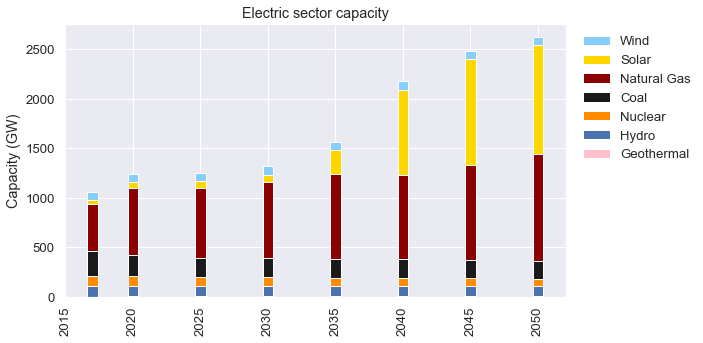

In [7]:
fig = plot_capacity_stacked(map_plants, col_order, con, 'test_run')
plt.title('Electric sector capacity')
plt.tight_layout()

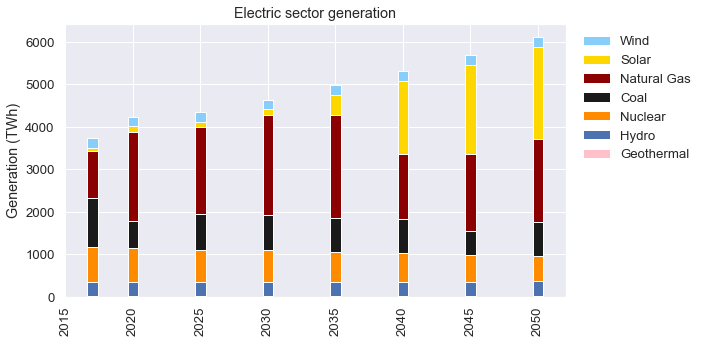

In [8]:
fig = plot_activity_stacked(map_plants, col_order, con, scenario)
plt.title('Electric sector generation')
plt.tight_layout()

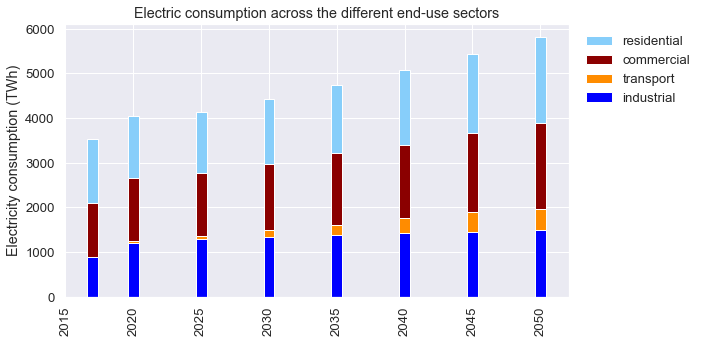

In [9]:
df_plot = get_elec_supply_sec(con, scenario)
fig = stacked_bar_plot(df_plot,[ 'industrial', 'transport', 'commercial','residential'])
plt.ylabel('Electricity consumption (TWh)')
plt.title('Electric consumption across the different end-use sectors')
plt.tight_layout()

In [10]:
#return sankey diagram dataframe for a sector
def stacked_penergy_sector(con, scenario, sector, region):
    if sector =='commercial':
        fuels_list = ['C_DISTOIL','C_LPG','C_NGA','C_RFO','ELC','SNG_100','H2_100', 'ELCDIST_R']
    elif sector=='residential':
        fuels_list = ['R_DISTOIL','R_LPG','R_NGA','R_KER','RWHSOL', 'R_BIO','ELC','SNG_100','H2_100', 'ELCDIST_R']
    elif sector == 'transport':
        fuels_list = ['MGO','DSL','GAS','CNG','ETHANOL', 'JTF', 'RFO', 'T_LPG','MEOH', 'T_Liquids', 'ELC', 'BIODSL', 'BIO_JTF', 'ELCDIST_R']
    elif sector == 'industrial':
        fuels_list = ['I_COAL', 'I_DFO', 'I_GSL',  'I_NGA', 'I_REN', 'I_RFO', 'I_LPG', 'I_OTH_EA', 'SNG_100', 'MEOH', 'H2_100', 'ELC', 'ELCDIST_R']
    else:
        print('Sector input is either residential, commercial, industrial, or transport')
    
    if region=='All':
        query = "SELECT input_comm, t_periods, SUM(vflow_in) AS vflow_in FROM Output_VFlow_In \
    WHERE scenario='" + scenario + "' AND sector='" + sector + \
    "' GROUP BY sector, input_comm, t_periods"
    else:
        query = "SELECT input_comm, t_periods, SUM(vflow_in) AS vflow_in FROM Output_VFlow_In \
    WHERE scenario='" + scenario + "' AND sector='" + sector + "' AND regions='"+ str(region) +\
    "' GROUP BY sector, input_comm, t_periods"

    df_sector = pd.read_sql_query(query, con)
    df_sector = df_sector[df_sector['input_comm'].isin(fuels_list)]
    

    df_sector = df_sector.pivot_table(values='vflow_in', index='input_comm', columns='t_periods')
    df_sector.fillna(0, inplace=True)
    return df_sector

### Technology/commodity look-up tool <a class="anchor" id="description_look_up"></a>
Use the tool below to retrieve the description for any technology or commodity within the database. Type the commodity or technology name in the box below to view the description. Note that names are case sensitive.

In [11]:
w = widgets.Text(value='ELC')
display(w)
def f(w):
    df = pd.read_sql("SELECT * FROM commodities WHERE comm_name='" + w + "'", con)
    if len(df)==0:
        df = pd.read_sql("SELECT * FROM technologies WHERE tech='" + w + "'", con)

    if len(df)>0:
        try:
            display(Markdown((df['comm_desc'].values[0].replace('#', '').strip())))
        except:
            display(Markdown(df['tech_desc'].values[0].replace('#', '').strip()))
    else:
        print('')


out = widgets.interactive_output(f, {'w': w})
display(out)


Text(value='ELC')

Output()